In [83]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python2  %%py

Here we will introduce how to get a point queue model for a HOT lane and GP lanes.
First of all, some values should be initialized as follows:

In [84]:
lambda1 = 0
lambda2 = 0
q1, C1 = 10.0, 30.0
q2, C2 = 60.0, 30.0
q3 = 0

If there are any vehicles waiting, which means congestion, the capacity would decrease (CAPACITY DROP).

In [85]:
def calCapacity(lambda1, lambda2):
    if lambda1 == 0:
        C1 = 30
    else:
        C1 = 30 * (1-0.1)
    if lambda2 ==0:
        C2 = 30
    else:
        C2 = 30 * (1-0.1)
    return C1, C2

Queue number in the HOT lane can be updated as:
$$\lambda_1(t+\Delta t) = max\{(q_1(t)+q_3(t)-C_1)\Delta t+\lambda_1 (t), 0\}$$
Similarly, queue number in the GP lane can be updated as:
$$\lambda_2(t+\Delta t) = max\{(q_2(t)-q_3(t)-C_2)\Delta t+\lambda_2 (t), 0\}$$

In [86]:
def updateQnum(q1, q2, q3, C1, C2, lambda1, lambda2):
    lambda1 = max((q1+q3-C1)/60.0 + lambda1, 0)
    lambda2 = max((q2-q3-C2)/60.0 + lambda2, 0)
    return lambda1, lambda2



The throughputs of HOT lane and GP can be calculated as:
$$g_1 (t)=min\{q_1 (t)+q_3 (t)+\frac {\lambda_1 (t)}{\epsilon}, C_1\}$$
$$g_2 (t)=min\{q_2 (t)-q_3 (t)+\frac {\lambda_2 (t)}{\epsilon}, C_2\}$$


In [99]:
def updateOutflow(q1, q2, q3, C1, C2, lambda1, lambda2):
    g1 = min(q1 + q3 + lambda1*1000000.0, C1)
    g2 = min(q2 - q3 + lambda2*1000000.0, C2)
    return g1, g2

    

Waiting time can be calculated as:
$$w_1 (t)=\frac {\lambda _1 (t)}{C_1}$$
$$w_2 (t)=\frac {\lambda _2 (t)}{C_2}$$
So the waiting time difference (total travel time difference) can be given by:
$$w(t)=w_2(t)-w_1(t)$$

In [88]:
def calTimeDif(lambda1, lambda2, C1, C2):
    w_dif = lambda2/C2 - lambda1/C1
    return w_dif

The probability of SOV driver choosing the HOT lane can be obtained:
$$Pr(t)=\frac{1}{1+{e}^{\alpha (u(t)-\pi w(t))}}$$
Therefore, the flow from GP lanes to the HOT lane can be given by:
$$q_3(t) = \frac{q_2(t)}{1+e^{\alpha (u(t)- \pi w(t)}}$$

In [1]:
import math
def calQ3(q2, u, w_dif):
    alpha = 1
    pi = 0.5
    q3 = q2 / (1 + math.exp(alpha*(u-pi*w_dif)))
    return q3



The toll is updated according to a feedback method from Yin and Lou.
$$u(t + \Delta t) = u(t) + K_I (q_{HOT} (t) - q^* _{HOT} (t))$$

In [90]:
def calPrice(u, q1, q3):
    u = u + 0.01 * (q1 + q3 - 30)
    return u

With all function defined, we would conduct a simulation without capacity drop.

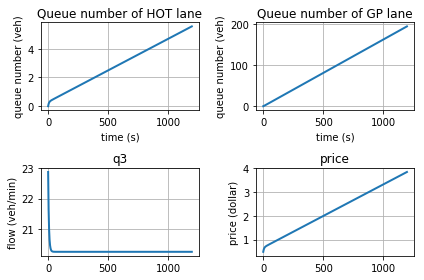

In [91]:
import matplotlib.pyplot as plt
###initialization
lambda1 = 0
lambda2 = 0
q1, C1 = 10.0, 30.0
q2, C2 = 60.0, 30.0
q3 = 0
w_dif = 0
u = math.log(2)

lambda1List = []
lambda2List = []
q3List = []
C1List = []
C2List = []
uList = []

for i in range(1200):
#     C1, C2 = calCapacity(lambda1, lambda2)
    C1List.append(C1)
    C2List.append(C2)
    q3 = calQ3(q2, u, w_dif)
    lambda1, lambda2 = updateQnum(q1, q2, q3, C1, C2, lambda1, lambda2)
    lambda1List.append(lambda1)
    lambda2List.append(lambda2)
    g1, g2 = updateOutflow(q1, q2, q3, C1, C2, lambda1, lambda2)
    w_dif = calTimeDif(lambda1, lambda2, C1, C2)
    u = calPrice(u, q1, q3)  #####
    uList.append(u)
    q3List.append(q3)

plt.subplot(2, 2, 1)
plt.plot(lambda1List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of HOT lane')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(lambda2List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of GP lane')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(q3List, '-', lw=2)
plt.ylabel('flow (veh/min)')
plt.title('q3')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(uList, '-', lw=2)

plt.ylabel('price (dollar)')
plt.title('price')
plt.grid(True)

plt.tight_layout()
plt.show()

For comparison, we would also conduct a simulation with capacity drop.

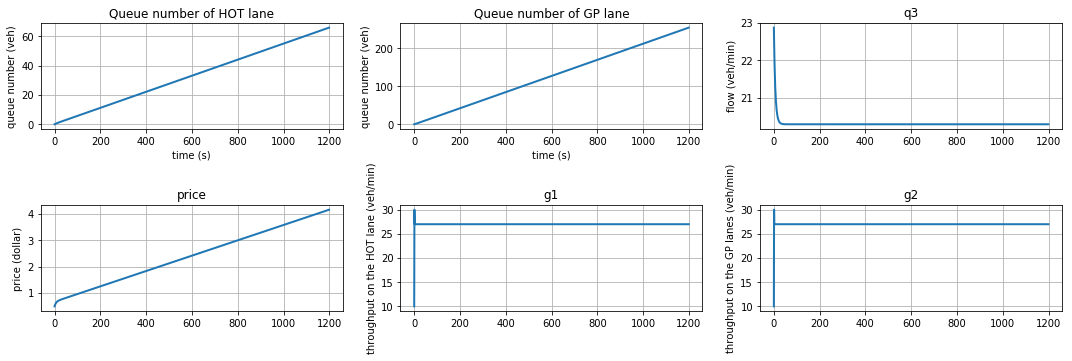

In [92]:
import matplotlib.pyplot as plt
###initialization
lambda1 = 0
lambda2 = 0
q1, C1 = 10.0, 30.0
q2, C2 = 60.0, 30.0
q3 = 0
u = math.log(2)

lambda1List = []
lambda2List = []
q3List = []
C1List = []
C2List = []
uList = []
g1List = []
g2List = []

for i in range(1200):
    C1, C2 = calCapacity(lambda1, lambda2)
    C1List.append(C1)
    C2List.append(C2)
    lambda1, lambda2 = updateQnum(q1, q2, q3, C1, C2, lambda1, lambda2)
    lambda1List.append(lambda1)
    lambda2List.append(lambda2)
    g1, g2 = updateOutflow(q1, q2, q3, C1, C2, lambda1, lambda2)
    w_dif = calTimeDif(lambda1, lambda2, C1, C2)
    u = calPrice(u, q1, q3)  #####
    uList.append(u)
    q3 = calQ3(q2, u, w_dif)
    q3List.append(q3)
    g1List.append(g1)
    g2List.append(g2)

plt.figure(1)
plt.figure(figsize=(15,5))

plt.subplot(2, 3, 1)
plt.plot(lambda1List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of HOT lane')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(lambda2List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of GP lane')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(q3List, '-', lw=2)
plt.ylabel('flow (veh/min)')
plt.title('q3')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(uList, '-', lw=2)

plt.ylabel('price (dollar)')
plt.title('price')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(g1List, '-', lw=2)

plt.ylabel('throughput on the HOT lane (veh/min)')
plt.title('g1')
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(g1List, '-', lw=2)

plt.ylabel('throughput on the GP lanes (veh/min)')
plt.title('g2')
plt.grid(True)

plt.tight_layout()
plt.show()

With capacity drop, both queue numbers of HOT lane and GP lanes increased.

The new method from Wang et al. also is used for comparison. In this method, the value of time (VOT) would be estimated, and then determine the price.
$$\pi (t+\Delta t) = \pi (t) + (K_1 \lambda _1 (t) - K_2 (C_1 - q_1 (t) - q_3 (t)))\Delta t$$
$$u(t) = \pi (t)w(t)+\frac{ln\frac{q_1 + q_2 - C_1}{C_1 - q1}}{\alpha}$$

In [104]:
def calPriceWANG(pi, w_dif, lambda1, C1, q1, q2, q3):
    K1, K2 = 0.1, 0.1
    alpha = 1
    pi_ = pi + (K1*lambda1 - K2*(C1 - q1 - q3))/60
    pi = pi_
    u = pi*w_dif + math.log((q1+q2-C1)/(C1-q1)) / alpha
    return u, pi

Firstly, we will evaluate the performance of this method without capacity drop.

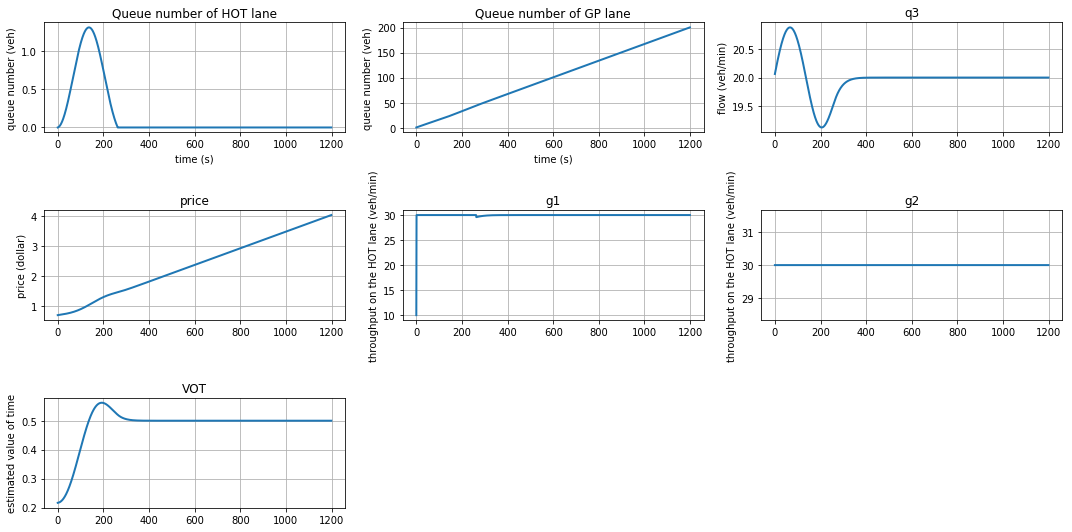

In [108]:
import matplotlib.pyplot as plt
###initialization
lambda1 = 0
lambda2 = 0
q1, C1 = 10.0, 30.0
q2, C2 = 60.0, 30.0
q3 = 0
u = math.log(2)
pi = 0.25

lambda1List = []
lambda2List = []
q3List = []
C1List = []
C2List = []
uList = []
g1List= []
g2List = []
piList = []

for i in range(1200):
#     C1, C2 = calCapacity(lambda1, lambda2)
    lambda1, lambda2 = updateQnum(q1, q2, q3, C1, C2, lambda1, lambda2)
    g1, g2 = updateOutflow(q1, q2, q3, C1, C2, lambda1, lambda2)
    w_dif = calTimeDif(lambda1, lambda2, C1, C2)
    u, pi_= calPriceWANG(pi, w_dif, lambda1, C1, q1, q2, q3)
    pi = pi_
    q3 = calQ3(q2, u, w_dif)
    
    piList.append(pi)
    g1List.append(g1)
    g2List.append(g2)
    C1List.append(C1)
    C2List.append(C2)
    uList.append(u)
    lambda1List.append(lambda1)
    lambda2List.append(lambda2)
    q3List.append(q3)

plt.figure(1)
plt.figure(figsize=(15,7.5))

plt.subplot(3, 3, 1)
plt.plot(lambda1List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of HOT lane')
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(lambda2List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of GP lane')
plt.grid(True)

plt.subplot(3, 3, 3)
plt.plot(q3List, '-', lw=2)
plt.ylabel('flow (veh/min)')
plt.title('q3')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(uList, '-', lw=2)
plt.ylabel('price (dollar)')
plt.title('price')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(g1List, '-', lw=2)
plt.ylabel('throughput on the HOT lane (veh/min)')
plt.title('g1')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(g2List, '-', lw=2)
plt.ylabel('throughput on the HOT lane (veh/min)')
plt.title('g2')
plt.grid(True)

plt.subplot(3, 3, 7)
plt.plot(piList, '-', lw=2)
plt.ylabel('estimated value of time')
plt.title('VOT')
plt.grid(True)

plt.tight_layout()
plt.show()

Then we will evaluate the performance of this method with capacity drop.

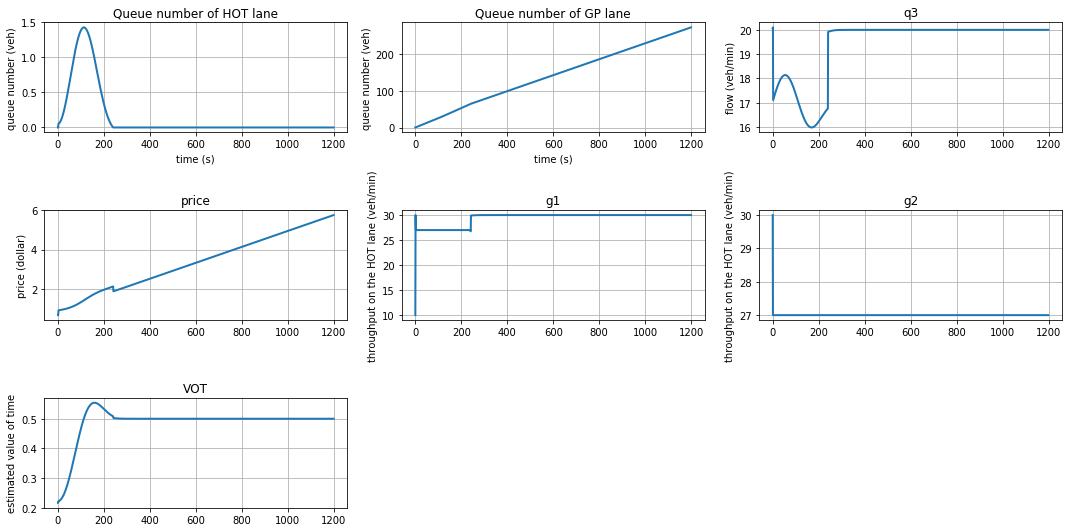

In [109]:
import matplotlib.pyplot as plt
###initialization
lambda1 = 0
lambda2 = 0
q1, C1 = 10.0, 30.0
q2, C2 = 60.0, 30.0
q3 = 0
u = math.log(2)
pi = 0.25

lambda1List = []
lambda2List = []
q3List = []
C1List = []
C2List = []
uList = []
g1List= []
g2List = []
piList = []

for i in range(1200):
    C1, C2 = calCapacity(lambda1, lambda2)
    lambda1, lambda2 = updateQnum(q1, q2, q3, C1, C2, lambda1, lambda2)
    g1, g2 = updateOutflow(q1, q2, q3, C1, C2, lambda1, lambda2)
    w_dif = calTimeDif(lambda1, lambda2, C1, C2)
    u, pi_= calPriceWANG(pi, w_dif, lambda1, C1, q1, q2, q3)
    pi = pi_
    q3 = calQ3(q2, u, w_dif)
    
    piList.append(pi)
    g1List.append(g1)
    g2List.append(g2)
    C1List.append(C1)
    C2List.append(C2)
    uList.append(u)
    lambda1List.append(lambda1)
    lambda2List.append(lambda2)
    q3List.append(q3)

plt.figure(1)
plt.figure(figsize=(15,7.5))

plt.subplot(3, 3, 1)
plt.plot(lambda1List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of HOT lane')
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(lambda2List, '-', lw=2)
plt.xlabel('time (s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of GP lane')
plt.grid(True)

plt.subplot(3, 3, 3)
plt.plot(q3List, '-', lw=2)
plt.ylabel('flow (veh/min)')
plt.title('q3')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(uList, '-', lw=2)
plt.ylabel('price (dollar)')
plt.title('price')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(g1List, '-', lw=2)
plt.ylabel('throughput on the HOT lane (veh/min)')
plt.title('g1')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(g2List, '-', lw=2)
plt.ylabel('throughput on the HOT lane (veh/min)')
plt.title('g2')
plt.grid(True)

plt.subplot(3, 3, 7)
plt.plot(piList, '-', lw=2)
plt.ylabel('estimated value of time')
plt.title('VOT')
plt.grid(True)

plt.tight_layout()
plt.show()